In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
from scipy.stats import ttest_rel
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
RAW_COUNTIES_FILENAME = 'us-counties.csv'
MASK_SURVEY_FILENAME = 'mask-use-by-county.csv'
COUNTY_VOTES_FILENAME = '2020_US_County_Level_Presidential_Results.csv'
raw_counties = pd.read_csv(RAW_COUNTIES_FILENAME)
mask_counties = pd.read_csv(MASK_SURVEY_FILENAME)
county_votes = pd.read_csv(COUNTY_VOTES_FILENAME)
county_votes.head()


,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [3]:
## Sorting by date
raw_counties['date'] = pd.to_datetime(raw_counties['date'])
sorted_counties = raw_counties.sort_values(by=['county','state','date'])

# Finding moving of cases
sorted_counties['mva_cases'] = sorted_counties['cases'].rolling(7).mean()
sorted_counties['new_cases'] = sorted_counties['mva_cases'].diff() 

## calculating R0
sorted_counties['R0']= sorted_counties.new_cases / sorted_counties.new_cases.shift()
diff_mask = (sorted_counties['county'] != sorted_counties['county'].shift(7)) & (sorted_counties['state'] != sorted_counties['state'].shift(7))
sorted_counties['new_cases'] = sorted_counties['new_cases'].where(~diff_mask, np.nan)

##cutting down on early days of covid spread where numbers are inconsistent and snr is low
filtered_counties = sorted_counties[sorted_counties['cases']>100]
filtered_counties = filtered_counties.drop(columns=['deaths','mva_cases']).replace([np.inf, -np.inf], np.nan).dropna()


In [4]:
avg_R0 = filtered_counties.groupby(['state','county','fips'])['R0'].mean().dropna()
avg_R0

state    county      fips   
Alabama  Autauga     1001.0     1.022149
         Baldwin     1003.0     1.017190
         Barbour     1005.0     1.017921
         Bibb        1007.0     1.009590
         Blount      1009.0     1.017486
                                  ...   
Wyoming  Sheridan    56033.0    1.034609
         Sweetwater  56037.0    1.005501
         Teton       56039.0    1.054017
         Uinta       56041.0    0.929780
         Washakie    56043.0    0.895239
Name: R0, Length: 2501, dtype: float64

In [5]:
mask_counties.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [6]:
def get_mask_wearage_avg(row):
    return (1*row['NEVER'] + 
            2*row['RARELY'] + 
            3*row['SOMETIMES'] +
            4*row['FREQUENTLY'] + 
            5*row['ALWAYS']) / 5

In [7]:
mask_counties['avg'] = mask_counties.apply(get_mask_wearage_avg, axis=1)
masks_just_avg = mask_counties.drop(columns=['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS'])

In [8]:
avg_R0 = pd.merge(avg_R0,masks_just_avg,how='inner',left_on='fips', right_on='COUNTYFP')
print(avg_R0)

            R0  COUNTYFP     avg
0     1.022149      1001  0.8006
1     1.017190      1003  0.7934
2     1.017921      1005  0.7856
3     1.009590      1007  0.8696
4     1.017486      1009  0.7784
...        ...       ...     ...
2421  1.034609     56033  0.6342
2422  1.005501     56037  0.6530
2423  1.054017     56039  0.7154
2424  0.929780     56041  0.6528
2425  0.895239     56043  0.6592

[2426 rows x 3 columns]


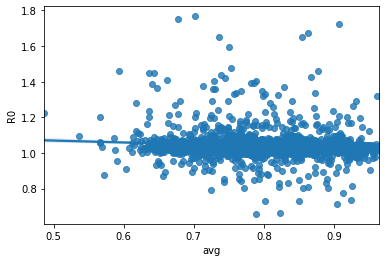

In [9]:
avg_R0= avg_R0[(avg_R0['R0']<2) & (avg_R0['R0']>.2)]
sns.regplot(avg_R0['avg'],avg_R0['R0'])

In [10]:
X2 = sm.add_constant(avg_R0['avg'])
est = sm.OLS(avg_R0['R0'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     R0   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     33.99
Date:                Tue, 29 Dec 2020   Prob (F-statistic):           6.27e-09
Time:                        23:45:03   Log-Likelihood:                 2953.0
No. Observations:                2418   AIC:                            -5902.
Df Residuals:                    2416   BIC:                            -5890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1237      0.015     74.963      0.0

In [11]:
county_votes['party'] = county_votes.apply(lambda row: 'gop' if row['votes_gop'] > row['votes_dem'] else 'dem', axis=1)
mask_and_party = pd.merge(mask_counties.drop(columns=['avg']),county_votes[['party','county_fips','per_dem']], left_on='COUNTYFP', right_on='county_fips', how='inner').drop(columns=['COUNTYFP','county_fips'])

In [36]:
mask_and_party_flattened = mask_and_party.drop(columns=['per_dem']).melt(var_name='frequency',id_vars='party',value_name='percent')
mask_and_party_flattened.head()

,party,frequency,percent
0,gop,NEVER,0.053
1,gop,NEVER,0.083
2,gop,NEVER,0.067
3,gop,NEVER,0.020
4,gop,NEVER,0.053


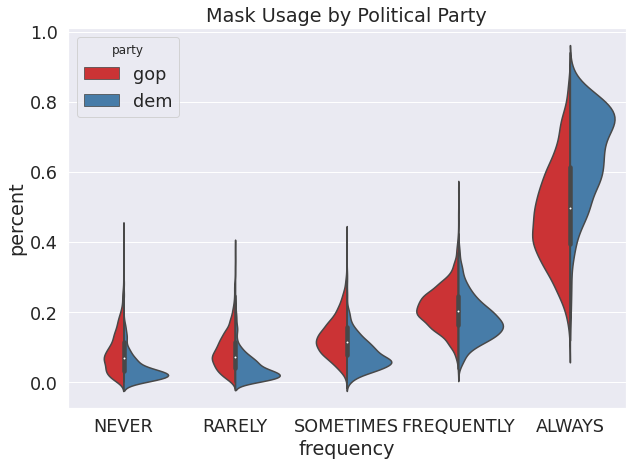

In [58]:
fig, axes = plt.subplots(figsize=(10, 7))
sns.set(font_scale=1.6)
ax = sns.violinplot(x='frequency', y='percent', hue="party",
                    data=mask_and_party_flattened, palette="Set1", split=True,
                    scale="area").set_title('Mask Usage by Political Party')

In [48]:
# Because it seems like the largest dichotomy of answers is between "always" and "frequently"
# Splitting will bin NEVER-RARELY into same bin

Text(0, 0.5, 'percent democratic votes')

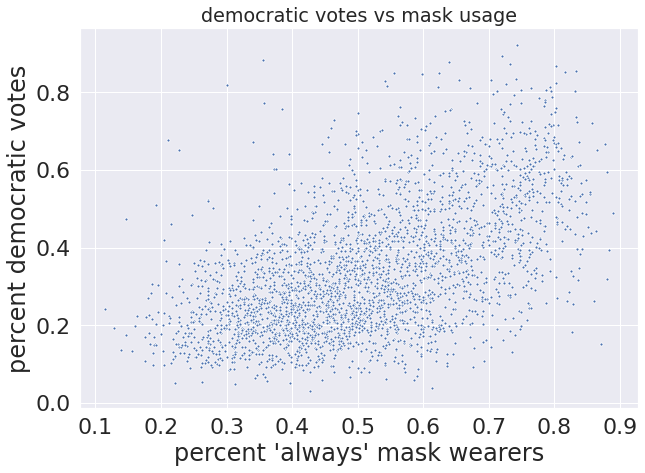

In [57]:
fig, axes = plt.subplots(figsize=(10, 7))
sns.set(font_scale=1.6)
mask_counties['NOT_ALWAYS'] = mask_counties[['NEVER','RARELY','SOMETIMES','FREQUENTLY']].sum(axis=1)
ax = sns.scatterplot(data=mask_and_party, x="ALWAYS", y="per_dem",marker="." ).set_title('democratic votes vs mask usage')
plt.xlabel('percent \'always\' mask wearers')
plt.ylabel('percent democratic votes')